### Conditional 1D example of `DDPM` using `Classifier-Free Guidance`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from util import (
    print_model_parameters,
    gp_sampler,
    get_torch_size_string,
    plot_1xN_torch_traj_tensor,
    periodic_step,
    plot_ddpm_1d_result,
)
from dataset import get_1d_training_data
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    DiffusionUNetLegacy,
    forward_sample,
    eval_ddpm_1d,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Init DDPM

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
# Instantiate U-net
device = 'mps' # mps, cpu
model = DiffusionUNetLegacy(
    name                 = 'unet',
    dims                 = 1,
    n_in_channels        = 1,
    n_base_channels      = 128,
    n_emb_dim            = 128,
    n_cond_dim           = 3,
    n_enc_blocks         = 4, # number of encoder blocks
    n_dec_blocks         = 4, # number of decoder blocks
    n_groups             = 16, # group norm paramter
    n_heads              = 4, # number of heads in QKV attention
    actv                 = nn.SiLU(),
    kernel_size          = 3, # kernel size (3)
    padding              = 1, # padding size (1)
    use_attention        = False,
    skip_connection      = True, # additional skip connection
    chnnel_multiples     = (1,2,4,8),
    updown_rates         = (1,2,2,2),
    use_scale_shift_norm = True,
    device               = device,
) # input:[B x C x L] => output:[B x C x L]
print ("Ready.")

Ready.


### Trainin data 
`x_0`:[N x C x L]
`c`: [N x d_cond]

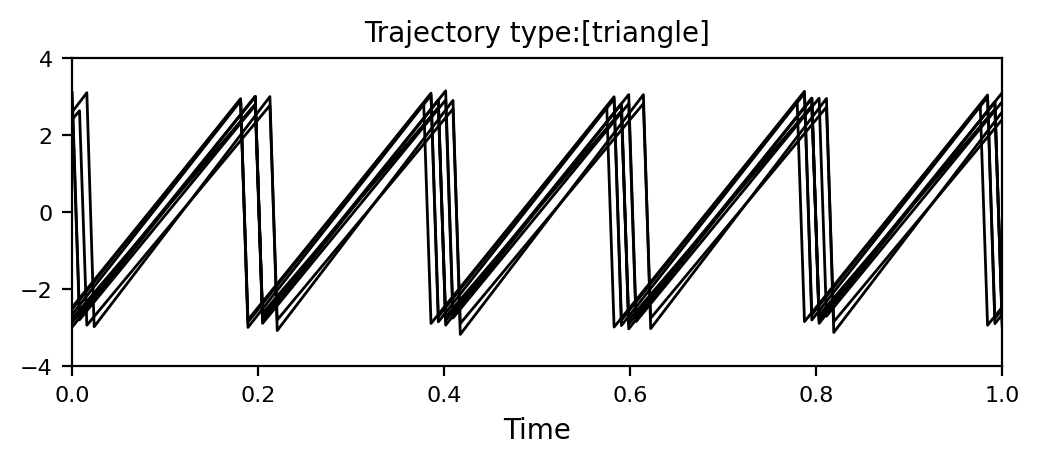

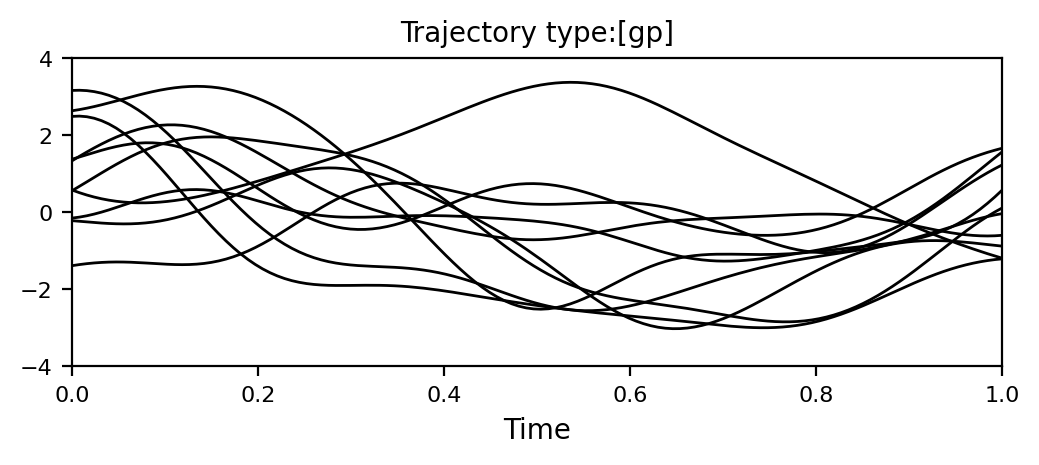

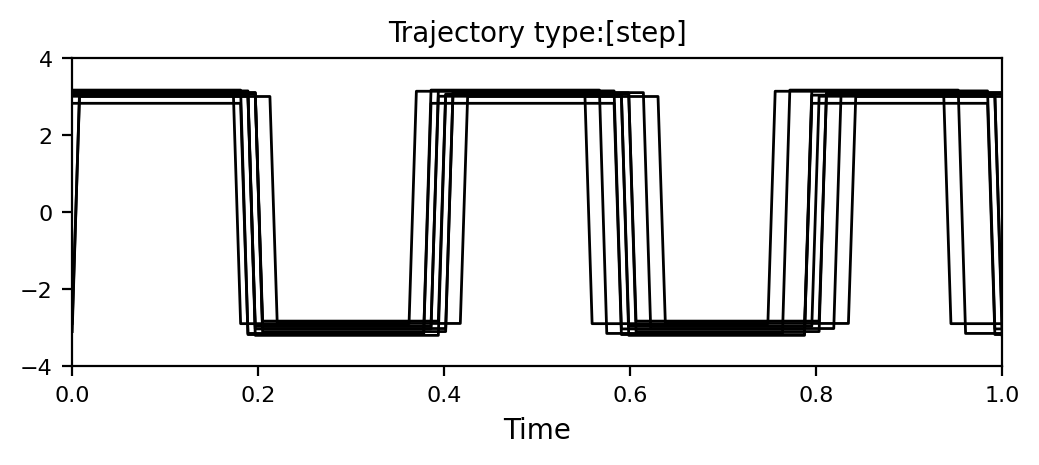

x_0:[30x1x128] cond:[30x3]


In [3]:
times,x_0_a = get_1d_training_data(
    traj_type = 'triangle', # gp / step / triange
    n_traj    = 10,
    L         = 128,
    device    = device,
    seed      = 0,
    plot_data = True,
    verbose   = False
    )
cond_a = th.tensor([1,0,0]).repeat(10,1).to(device)

times,x_0_b = get_1d_training_data(
    traj_type = 'gp', # gp / step / triange
    n_traj    = 10,
    L         = 128,
    device    = device,
    seed      = 0,
    plot_data = True,
    verbose   = False
    )
cond_b = th.tensor([0,1,0]).repeat(10,1).to(device)

times,x_0_c = get_1d_training_data(
    traj_type = 'step', # gp / step / triange
    n_traj    = 10,
    L         = 128,
    device    = device,
    seed      = 0,
    plot_data = True,
    verbose   = False
    )
cond_c = th.tensor([0,0,1]).repeat(10,1).to(device)

# Concat
x_0 = th.cat([x_0_a,x_0_b,x_0_c],dim=0)
cond = th.cat([cond_a,cond_b,cond_c],dim=0).to(th.float32)
print ("x_0:[%s] cond:[%s]"%
       (get_torch_size_string(x_0),get_torch_size_string(cond)))

### Train

it:[      0][0.0]% loss:[0.9559]


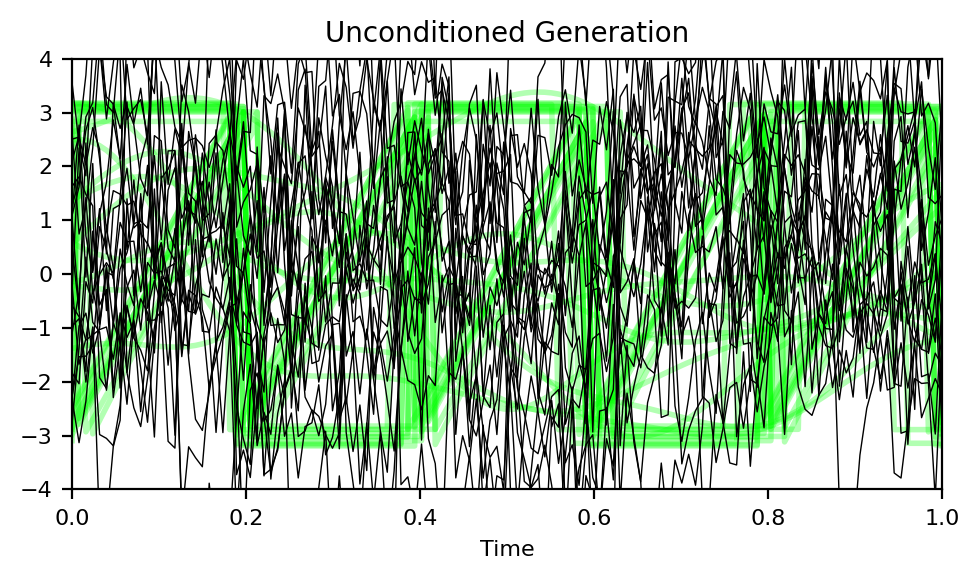

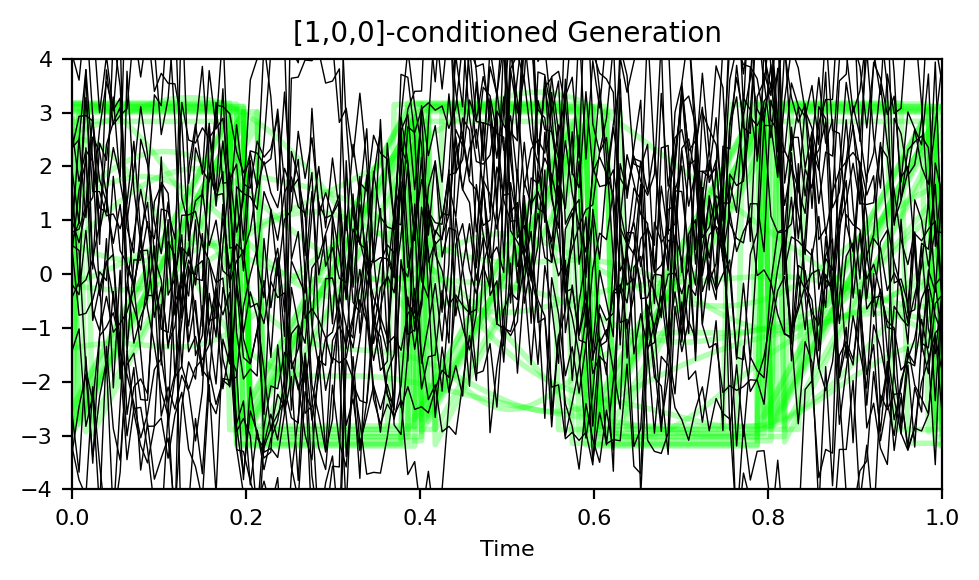

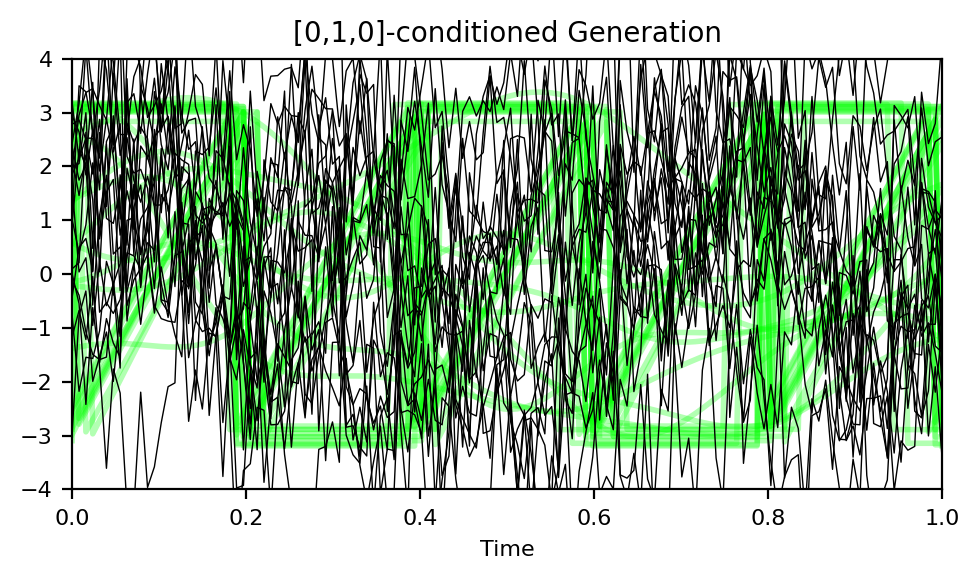

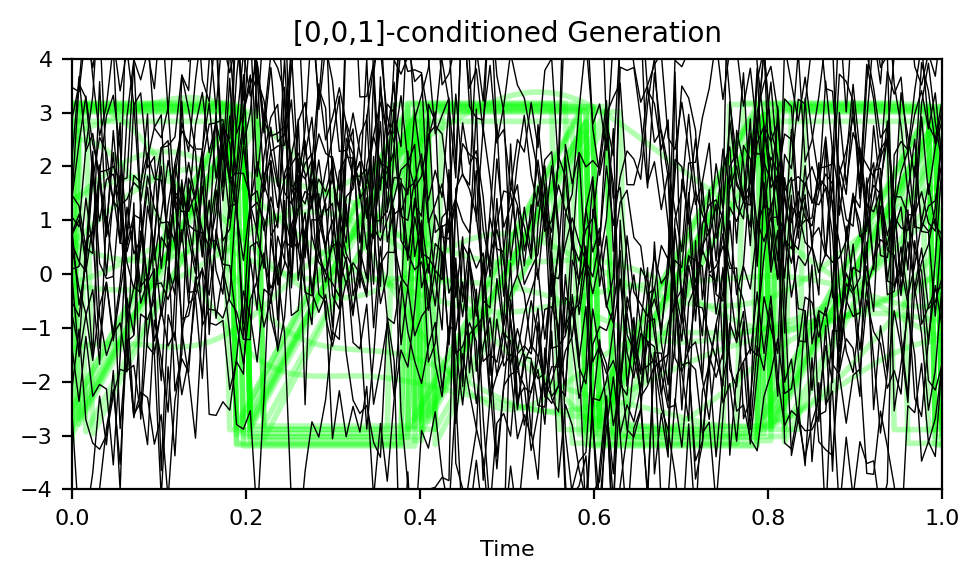

it:[   1000][5.0]% loss:[0.1000]
it:[   2000][10.0]% loss:[0.0708]
it:[   3000][15.0]% loss:[0.0651]
it:[   4000][20.0]% loss:[0.0523]
it:[   5000][25.0]% loss:[0.0513]


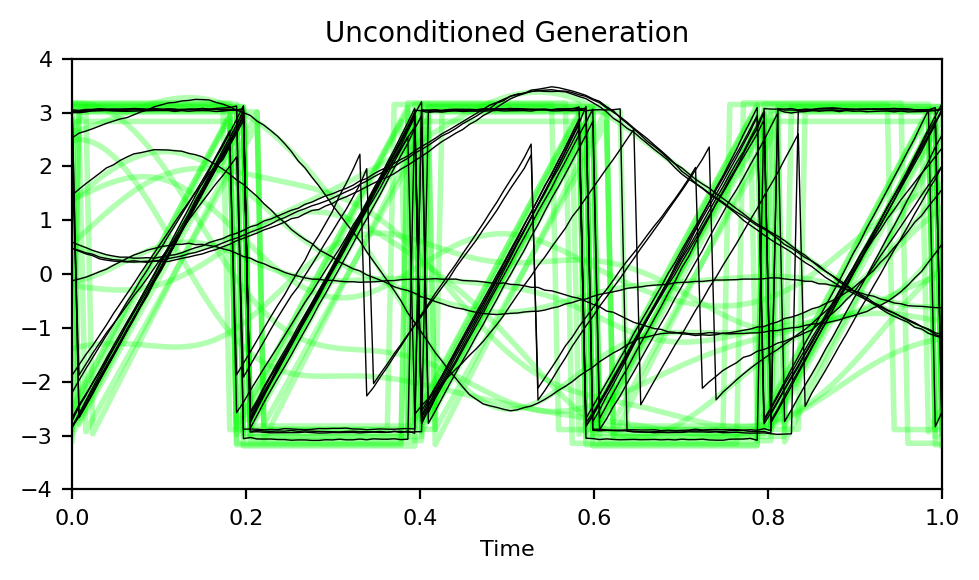

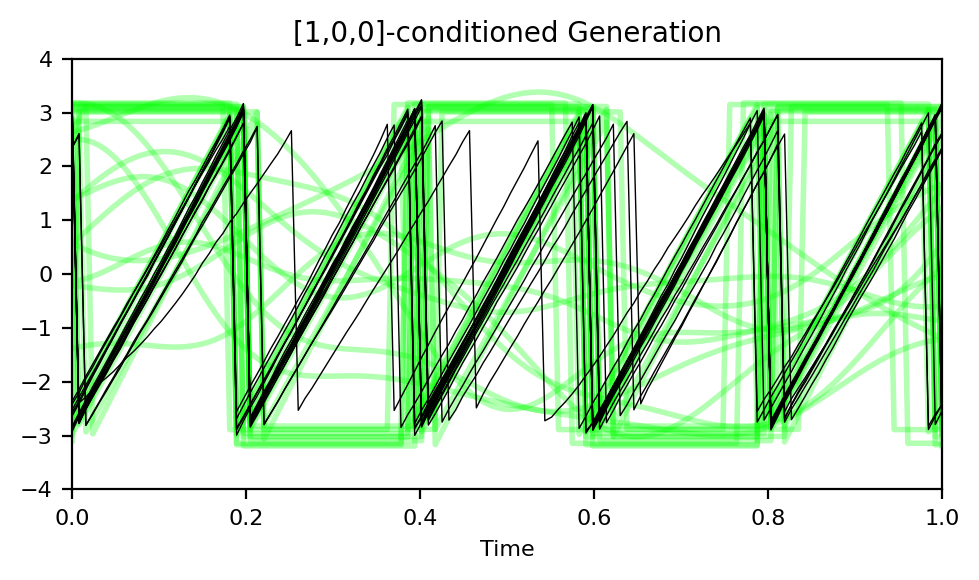

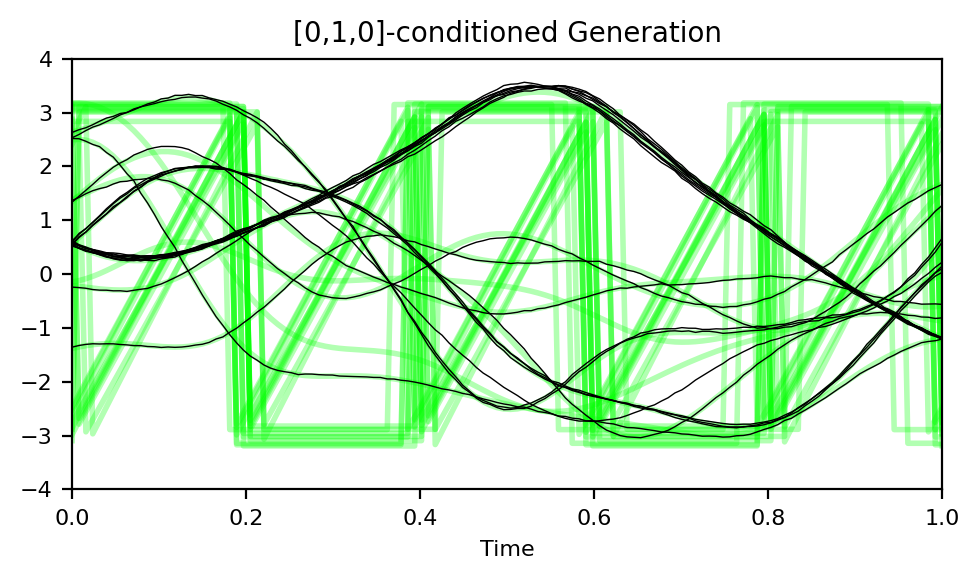

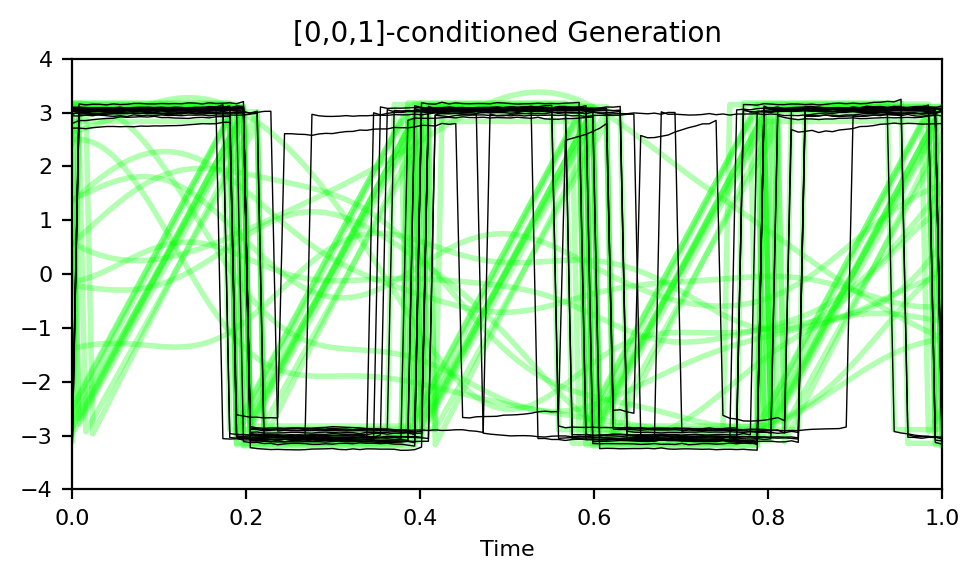

it:[   6000][30.0]% loss:[0.0452]
it:[   7000][35.0]% loss:[0.0408]
it:[   8000][40.0]% loss:[0.0326]
it:[   9000][45.0]% loss:[0.0381]
it:[  10000][50.0]% loss:[0.0357]


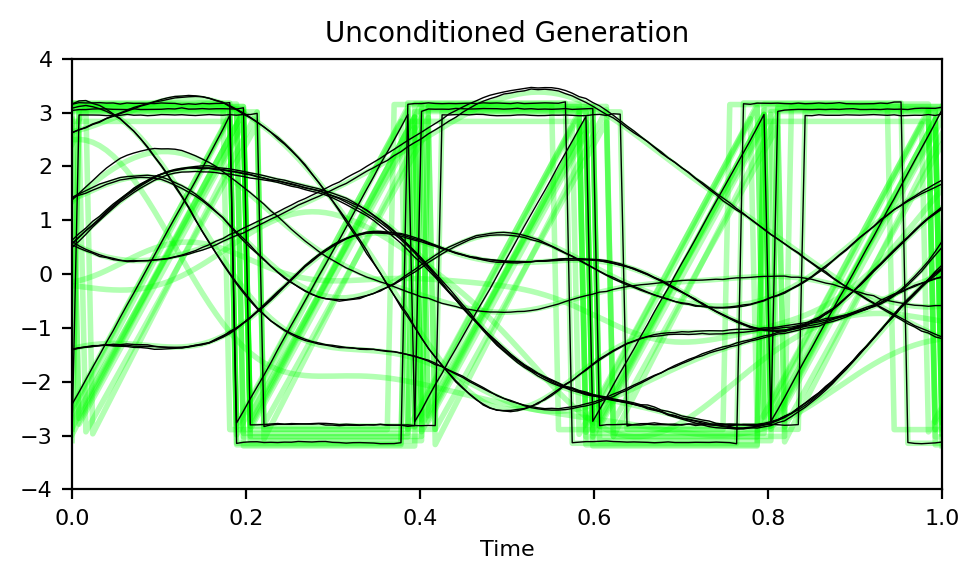

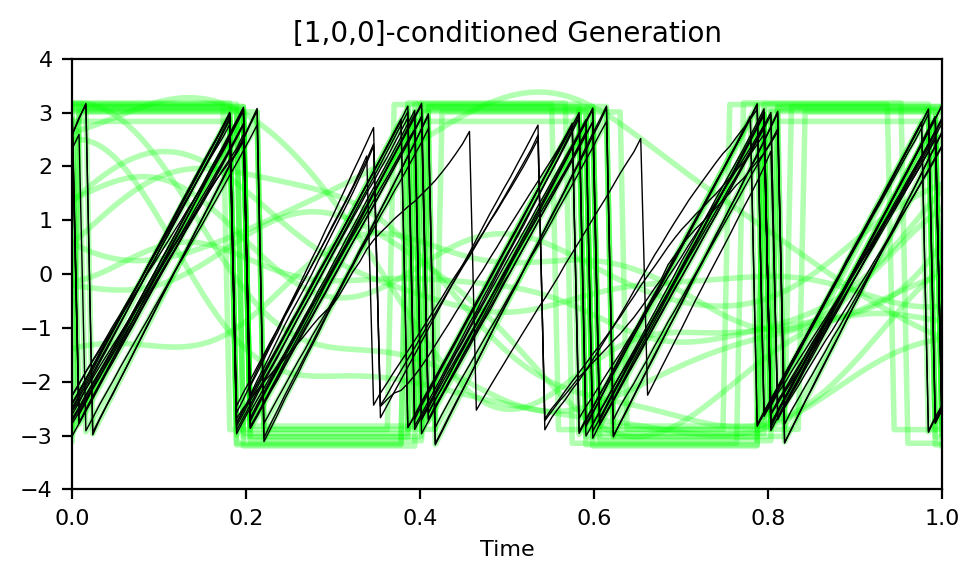

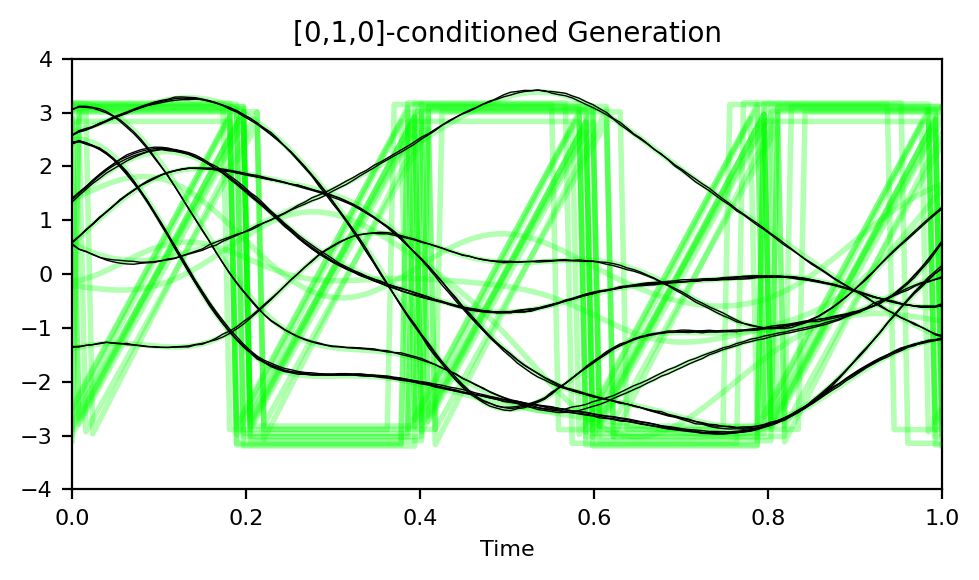

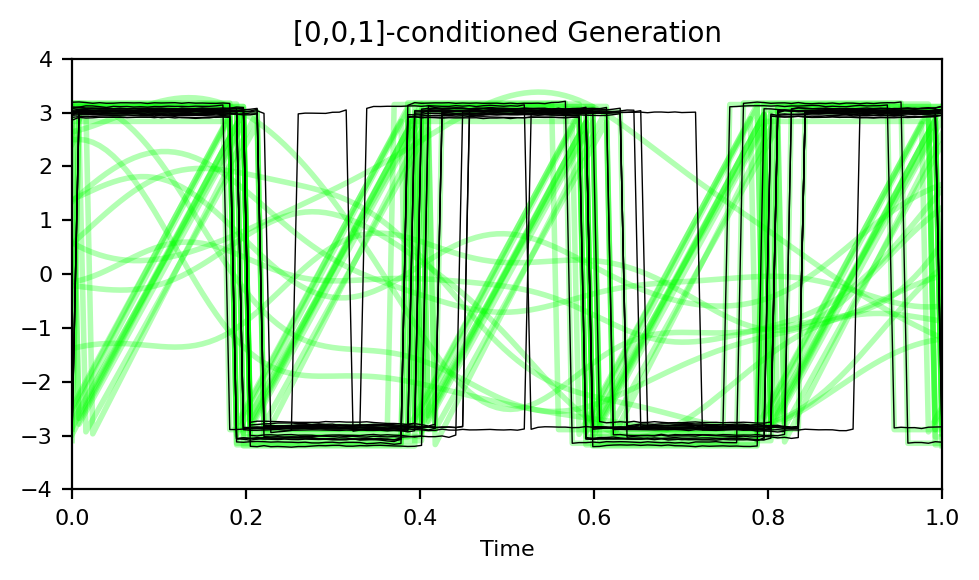

it:[  11000][55.0]% loss:[0.0424]
it:[  12000][60.0]% loss:[0.0330]
it:[  13000][65.0]% loss:[0.0413]
it:[  14000][70.0]% loss:[0.0321]
it:[  15000][75.0]% loss:[0.0330]


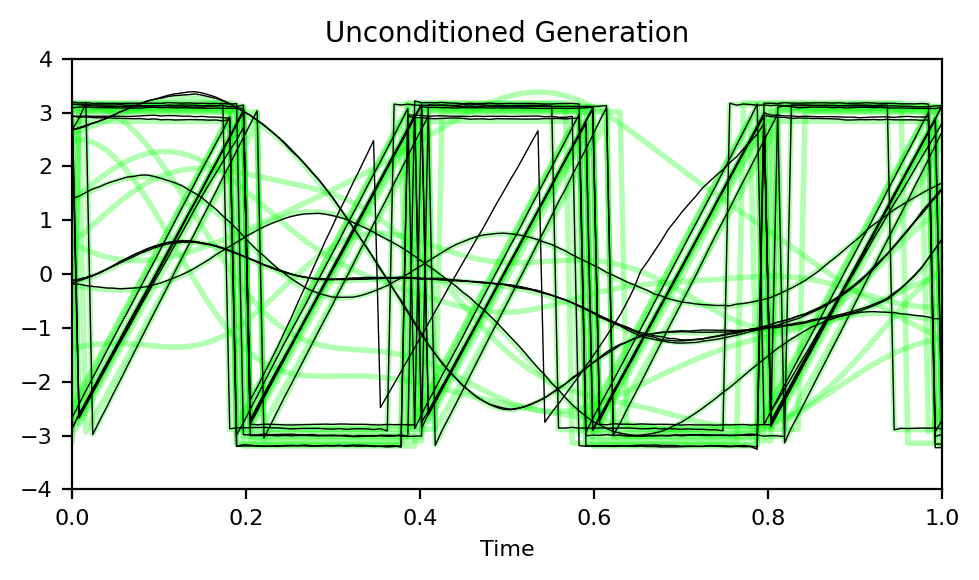

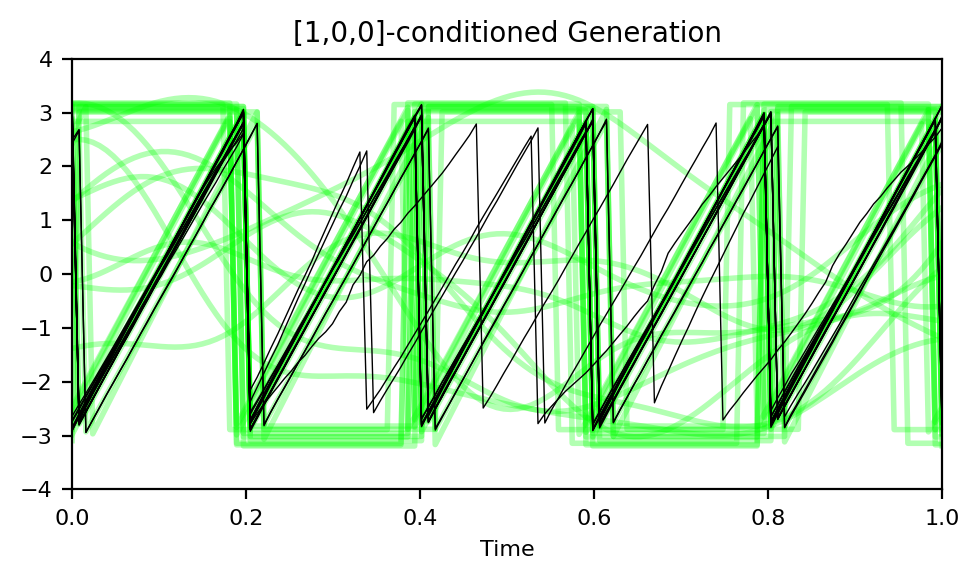

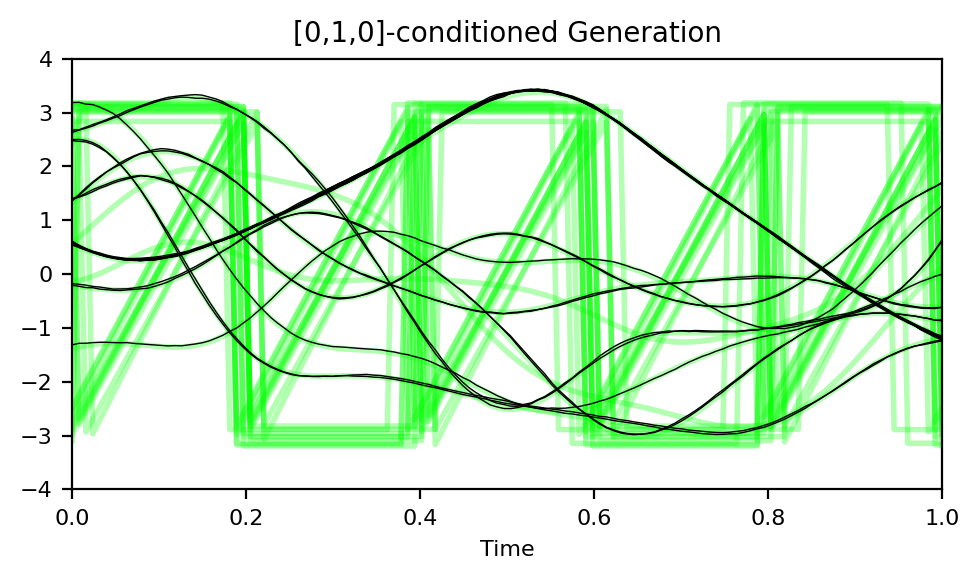

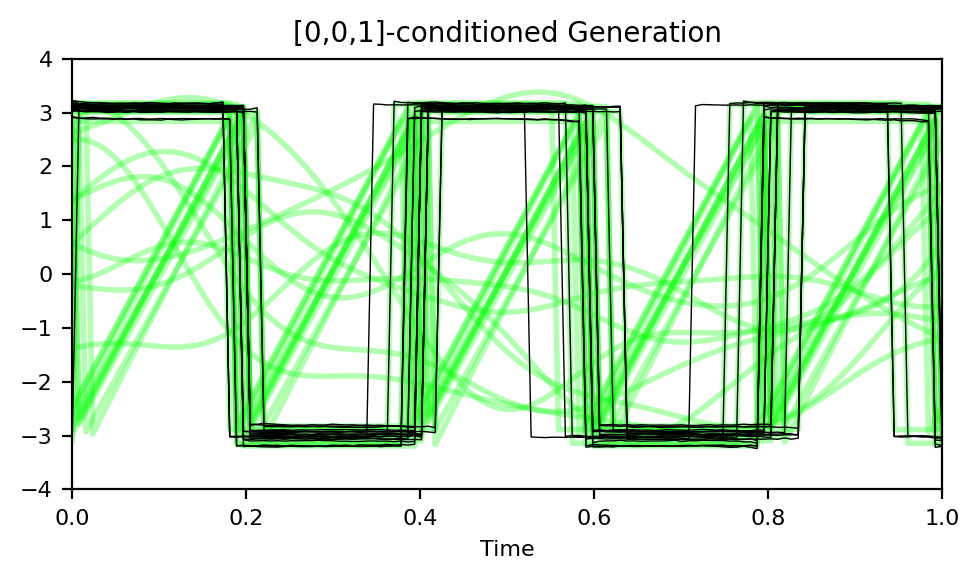

it:[  16000][80.0]% loss:[0.0281]
it:[  17000][85.0]% loss:[0.0281]
it:[  18000][90.0]% loss:[0.0365]
it:[  19000][95.0]% loss:[0.0296]
it:[  19999][100.0]% loss:[0.0331]


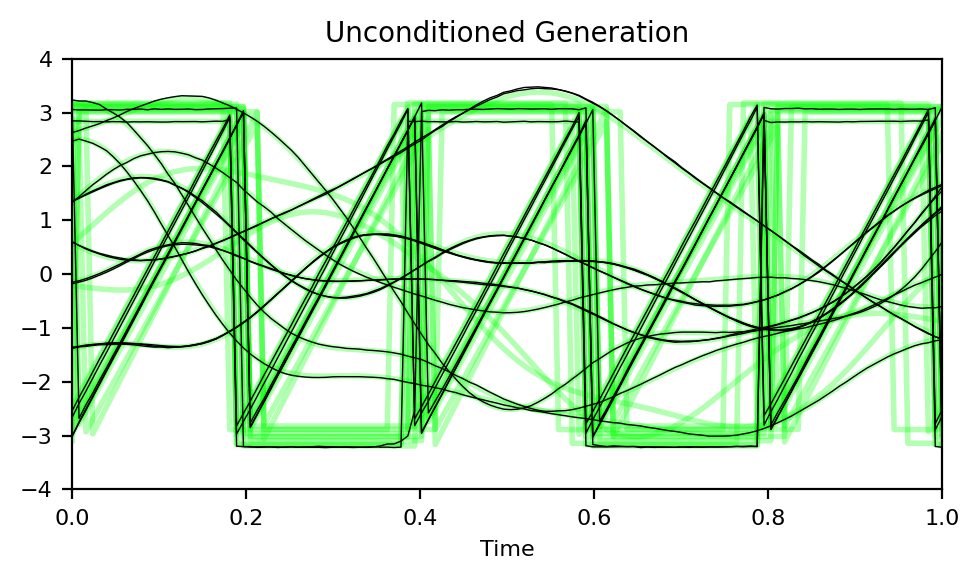

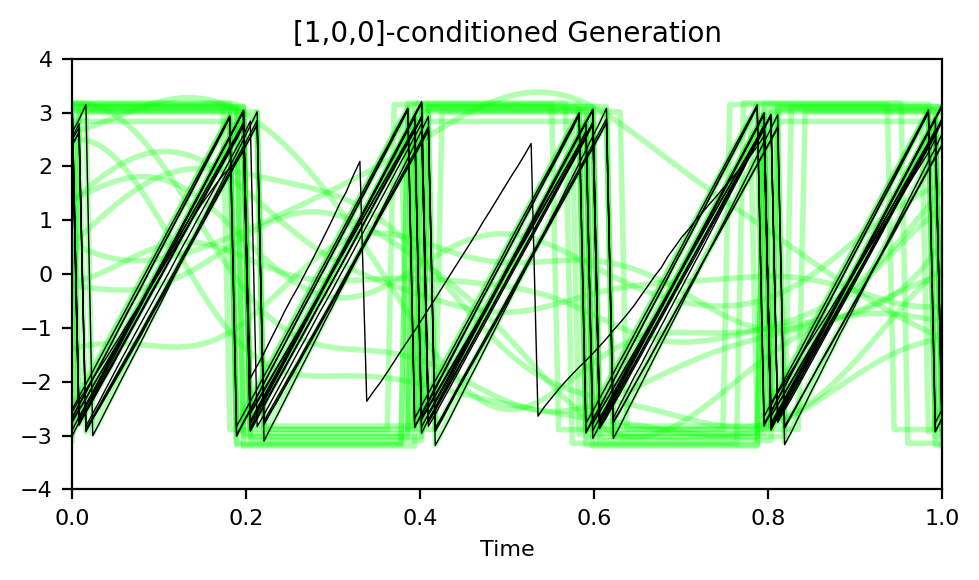

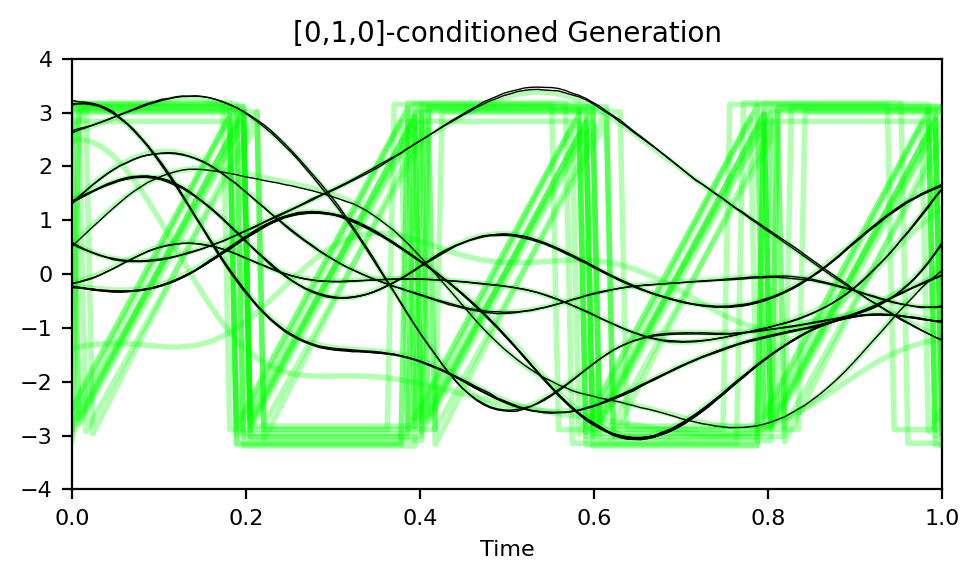

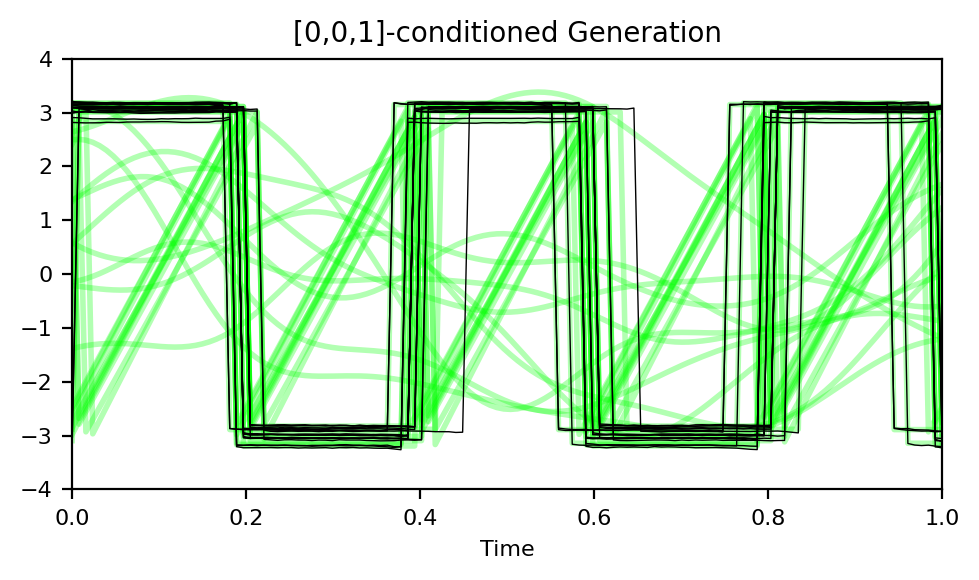

Done.


In [4]:
# Configuration
max_iter    = int(2e4)
batch_size  = 128
print_every = 1e3
eval_every  = 5e3
p_uncond    = 0.1

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    
    # Zero gradient
    optm.zero_grad()
    
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:] # [B x C x L]
    cond_batch = cond[idx,:] # [B x d_cond]
    idx_uncond = np.random.choice(batch_size,int(batch_size*p_uncond))
    cond_batch[idx_uncond,:] = 0
    
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).long() # [B]
    
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x L]

    # Noise prediction
    noise_pred,_ = model(x_t_batch,step_batch,cond_batch) # [B x C x L]
    
    # Compute error
    loss = F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    
    # Update
    loss.backward()
    optm.step()
    schd.step()
    
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts

        # Unconditioned
        lw_gt,lw_sample = 2,1/2
        lc_gt,lc_sample=(0,1,0,0.3),'k',
        cond_eval = th.tensor([0,0,0]).to(th.float32).to(device)
        x_t_list = eval_ddpm_1d(model,dc,n_sample,x_0,step_list_to_append,device,cond=cond_eval)
        plot_ddpm_1d_result(
            times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
            plot_ancestral_sampling=False,
            plot_one_sample=False,lw_gt=lw_gt,lw_sample=lw_sample,lc_gt=lc_gt,lc_sample=lc_sample,
            ylim=(-4,+4),figsize=(5,3),title_str='Unconditioned Generation')

        # Conditioned
        cond_eval = th.tensor([1,0,0]).to(th.float32).to(device)
        x_t_list = eval_ddpm_1d(model,dc,n_sample,x_0,step_list_to_append,device,cond=cond_eval)
        plot_ddpm_1d_result(
            times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
            plot_ancestral_sampling=False,
            plot_one_sample=False,lw_gt=lw_gt,lw_sample=lw_sample,lc_gt=lc_gt,lc_sample=lc_sample,
            ylim=(-4,+4),figsize=(5,3),title_str='[1,0,0]-conditioned Generation')

        cond_eval = th.tensor([0,1,0]).to(th.float32).to(device)
        x_t_list = eval_ddpm_1d(model,dc,n_sample,x_0,step_list_to_append,device,cond=cond_eval)
        plot_ddpm_1d_result(
            times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
            plot_ancestral_sampling=False,
            plot_one_sample=False,lw_gt=lw_gt,lw_sample=lw_sample,lc_gt=lc_gt,lc_sample=lc_sample,
            ylim=(-4,+4),figsize=(5,3),title_str='[0,1,0]-conditioned Generation')

        cond_eval = th.tensor([0,0,1]).to(th.float32).to(device)
        x_t_list = eval_ddpm_1d(model,dc,n_sample,x_0,step_list_to_append,device,cond=cond_eval)
        plot_ddpm_1d_result(
            times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
            plot_ancestral_sampling=False,
            plot_one_sample=False,lw_gt=lw_gt,lw_sample=lw_sample,lc_gt=lc_gt,lc_sample=lc_sample,
            ylim=(-4,+4),figsize=(5,3),title_str='[0,0,1]-conditioned Generation')

print ("Done.")